In [76]:
#Goal of this notebook: Given early engagement numbers (likes, shares, comments, diggs, upload hour, etc.) 
# → predict how many views the video will eventually reach.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [77]:
# Load training data
df = pd.read_csv("train.csv")

In [78]:
df_clean = df[[
    "digg_count",
    "share_count",
    "repost_count",
    "collect_count",
    "comment_count",
    "duration",
    "create_time",
    "play_count"
]].copy()

In [79]:
# Check data shape and missing values
print(f"Shape: {df_clean.shape}")
print(f"Missing values: {df_clean.isnull().sum().sum()}")

Shape: (2060, 8)
Missing values: 21


In [80]:
#there are only few rows which have missing/null data, we will just remove them because it won't create a significant 
#difference with our result

In [81]:
df_clean = df_clean.dropna()

In [82]:
# Data cleaned - ready for feature engineering
#FEATURE ENGINEERING: create_time has the date time basically, but we want the hour it was posted (cause that's more crucial)

In [83]:
from datetime import datetime

df_clean["upload_hour"] = df_clean["create_time"].apply(
    lambda x: datetime.fromtimestamp(x).hour
)

df_clean = df_clean.drop("create_time", axis=1)


In [84]:
# Verify feature engineering
print(f"Final shape: {df_clean.shape}")
print(f"Upload hour range: {df_clean['upload_hour'].min()} - {df_clean['upload_hour'].max()}")

Final shape: (2057, 8)
Upload hour range: 0 - 23


In [85]:
#We are going to do ratio features (powerful feature engineering)
#Because they show quality of engagement, not just quantity.

#Examples:
# - A video with 100 comments on 1000 likes is strong.
# - A video with 10 comments on 10,000 likes is weak.

In [86]:
df_clean["like_per_comment"] = df_clean["digg_count"] / (df_clean["comment_count"] + 1)
df_clean["share_per_like"] = df_clean["share_count"] / (df_clean["digg_count"] + 1)

# High value → people like but don’t comment → low interaction
# Low value → comments are high relative to likes → high interaction

# High → people share the video more than they like it → viral content
# Low → people don't find it shareable

In [87]:
df_clean = df_clean.drop("repost_count", axis=1)

In [88]:
from sklearn.model_selection import train_test_split

X = df_clean.drop("play_count", axis=1)

# Log transform target to make distribution more normal
y_log = np.log1p(df_clean["play_count"])
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

In [89]:
# Scale features for better model performance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


In [90]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [91]:
#RANDOM FOREST REGRESSOR

In [92]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [93]:
rf = RandomForestRegressor(
    n_estimators=300,     # number of trees
    max_depth=None,       # let trees grow fully
    random_state=42,
    n_jobs=-1             # use all CPU cores for speed
)

rf.fit(X_train_scaled, y_train_log)

,n_estimators,300
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [94]:
#predicts in log scale
preds_log = rf.predict(X_test_scaled)

#converts back to real play_count
preds = np.expm1(preds_log)
actual = np.expm1(y_test_log)

In [95]:
# Baseline Random Forest performance
r2_baseline = r2_score(y_test_log, preds_log)
mse_baseline = mean_squared_error(y_test_log, preds_log)
print(f"R2 (log space): {r2_baseline:.4f}")
print(f"RMSE (log space): {np.sqrt(mse_baseline):.4f}")

R2 (log space): 0.8993
RMSE (log space): 0.3522


In [96]:
# now we try to find the best parameter by hyperparameter tuning 

In [97]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

In [98]:
param_dist = {
    "n_estimators": [200, 300, 400, 500, 600],
    "max_depth": [10, 20, 30, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["auto", "sqrt", 0.5],
    "bootstrap": [True, False]
}

In [99]:
# Hyperparameter tuning with cross-validation
rf_base = RandomForestRegressor(random_state=42)

rf_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=30,
    cv=3,
    verbose=0,  # Reduced verbosity
    scoring="r2",
    random_state=42,
    n_jobs=-1
)

In [100]:

rf_search.fit(X_train_scaled, y_train_log)


/opt/homebrew/lib/python3.14/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
21 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
11 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.14/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/lib/python3.14/site-packages/sklearn/base.py", line 1358, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/opt/homebrew/lib/python3.14/site-packages/sklearn/base.py", line 471, in _validate_params
    

,estimator,RandomForestR...ndom_state=42)
,param_distributions,"{'bootstrap': [True, False], 'max_depth': [10, 20, ...], 'max_features': ['auto', 'sqrt', ...], 'min_samples_leaf': [1, 2, ...], ...}"
,n_iter,30
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [101]:
# Best hyperparameters found
print(f"Best CV R2 score: {rf_search.best_score_:.4f}")
print(f"Best parameters: {rf_search.best_params_}")

Best CV R2 score: 0.8946
Best parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 0.5, 'max_depth': 30, 'bootstrap': True}


In [102]:
# Evaluate best model
best_rf = rf_search.best_estimator_

preds_log = best_rf.predict(X_test_scaled)
preds = np.expm1(preds_log)
actual = np.expm1(y_test_log)

r2_log = r2_score(y_test_log, preds_log)
r2_original = r2_score(actual, preds)
rmse_log = np.sqrt(mean_squared_error(y_test_log, preds_log))

print(f"R2 (log space): {r2_log:.4f}")
print(f"RMSE (log space): {rmse_log:.4f}")
print(f"\nNote: R2 in log space ({r2_log:.4f}) is the correct metric since model was trained on log-transformed data.")

R2 (log space): 0.9048
RMSE (log space): 0.3425

Note: R2 in log space (0.9048) is the correct metric since model was trained on log-transformed data.


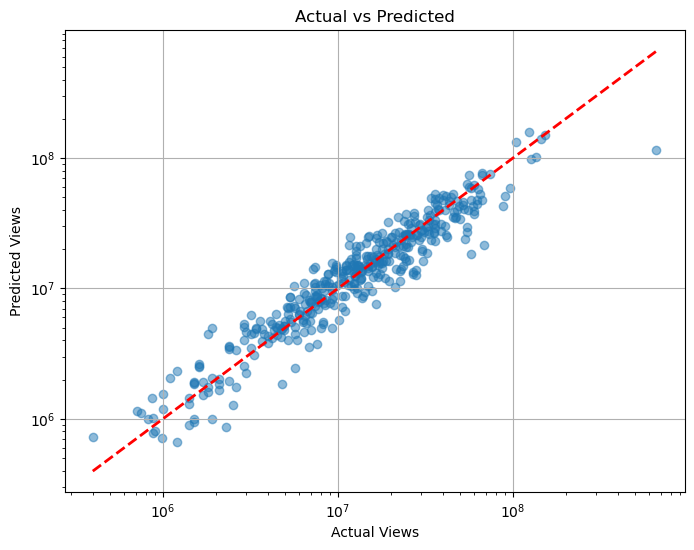

In [115]:
# Visualize model performance
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(actual, preds, alpha=0.5)

max_val = max(max(actual), max(preds))
min_val = min(min(actual), min(preds))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

plt.xlabel("Actual Views")
plt.ylabel("Predicted Views")
plt.title("Actual vs Predicted")
plt.xscale("log")
plt.yscale("log")
plt.grid(True)
plt.show()


In [104]:
# summary 
#RandomForestRegressor:

#Builds N different decision trees (e.g., 100, 300, 500…)

# Each tree is trained on a random subset of:
# - the data (rows)
# - the features (columns)
# - Each tree makes a prediction
# The final prediction = average of all tree predictions
# This reduces overfitting and improves accuracy.
# reduces Sensitivity to noise

In [105]:
# this is the best model so far
# thus, testing some data to check what our model predicts:

In [106]:

# -------------------------
# 1. Features used in training
# -------------------------
FEATURES = [
    'digg_count', 'share_count', 'collect_count', 'comment_count',
    'duration', 'upload_hour', 'like_per_comment', 'share_per_like'
]



# -------------------------
# 2. Prepare input to match training columns
# -------------------------
def prepare_input(video_features):
    df = pd.DataFrame([video_features])
    
    # Calculate ratio features from raw counts (same as training)
    df['like_per_comment'] = df['digg_count'] / (df['comment_count'] + 1)
    df['share_per_like'] = df['share_count'] / (df['digg_count'] + 1)
    
    # Ensure all required columns exist
    for col in FEATURES:
        if col not in df.columns:
            df[col] = 0
    
    # Return in correct order
    return df[FEATURES]


# -------------------------
# 3. Predict final views
# -------------------------
def predict_video(model, scaler, video_features):
    df = prepare_input(video_features)
    
    # Convert to numpy array to avoid feature name warnings
    df_array = df.values
    
    # Scale like training
    df_scaled = scaler.transform(df_array)
    
    # Predict log-space views
    pred_log = model.predict(df_scaled)
    
    # Convert back to actual views
    return np.expm1(pred_log)[0]

In [107]:
# Test cases with realistic values within training distribution
# Training range: digg_count (19,900 - 25,400,000), share_count (299 - 10,200,000)
from datetime import datetime

weak_video = {
    "digg_count": 50000,      # Low end (25th percentile ~357k, but using 50k for weak)
    "share_count": 500,       # Low engagement
    "collect_count": 500,
    "comment_count": 500,
    "duration": 15,
    "upload_hour": 3
}

normal_video = {
    "digg_count": 800000,     # Around median (825,600)
    "share_count": 8000,      # Around median (8,480)
    "collect_count": 26000,   # Around median (26,424)
    "comment_count": 7600,    # Around median (7,615)
    "duration": 40,           # Around median
    "upload_hour": 14
}

viral_video = {
    "digg_count": 5000000,    # High engagement (75th percentile ~1.8M)
    "share_count": 100000,    # High shares
    "collect_count": 200000,  # High collects
    "comment_count": 50000,   # High comments
    "duration": 20,
    "upload_hour": 20
}

# Real video from dataset (zachking - "#MamaSaid to always be a gentleman")
real_video = {
    "digg_count": 1100000,
    "share_count": 637,
    "collect_count": 467,
    "comment_count": 1988,
    "duration": 15,
    "upload_hour": datetime.fromtimestamp(1468105536).hour  # Extract hour from timestamp
}


/opt/homebrew/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


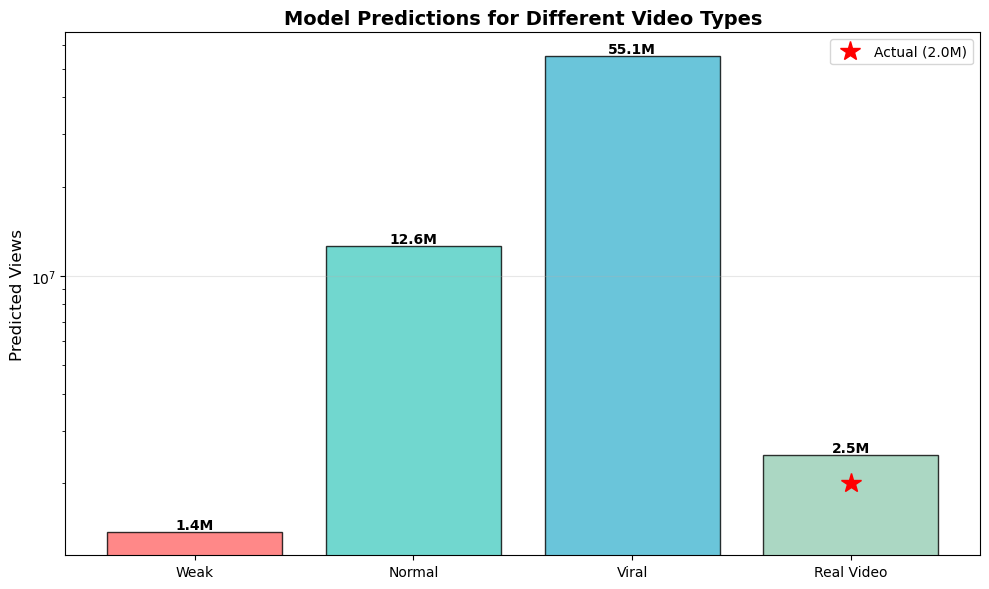

Weak: 1,370,047 | Normal: 12,573,704 | Viral: 55,112,225
Real video: 2,490,118 (actual: 2,000,000, error: 24.5%)


In [108]:
# Test predictions on sample videos
weak_pred = predict_video(best_rf, scaler, weak_video)
normal_pred = predict_video(best_rf, scaler, normal_video)
viral_pred = predict_video(best_rf, scaler, viral_video)
real_pred = predict_video(best_rf, scaler, real_video)

# Create visualization
fig, ax = plt.subplots(figsize=(10, 6))
categories = ['Weak', 'Normal', 'Viral', 'Real Video']
predictions = [weak_pred, normal_pred, viral_pred, real_pred]
colors = ['#ff6b6b', '#4ecdc4', '#45b7d1', '#96ceb4']

bars = ax.bar(categories, predictions, color=colors, alpha=0.8, edgecolor='black')
ax.set_ylabel('Predicted Views', fontsize=12)
ax.set_title('Model Predictions for Different Video Types', fontsize=14, fontweight='bold')
ax.set_yscale('log')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, pred in zip(bars, predictions):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{pred/1e6:.1f}M',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add actual value for real video
actual_views = 2000000
ax.plot(3, actual_views, 'r*', markersize=15, label='Actual (2.0M)')
ax.legend()

plt.tight_layout()
plt.show()

# Summary
print(f"Weak: {weak_pred:,.0f} | Normal: {normal_pred:,.0f} | Viral: {viral_pred:,.0f}")
actual_views = 2000000
print(f"Real video: {real_pred:,.0f} (actual: {actual_views:,}, error: {abs(real_pred - actual_views) / actual_views * 100:.1f}%)")


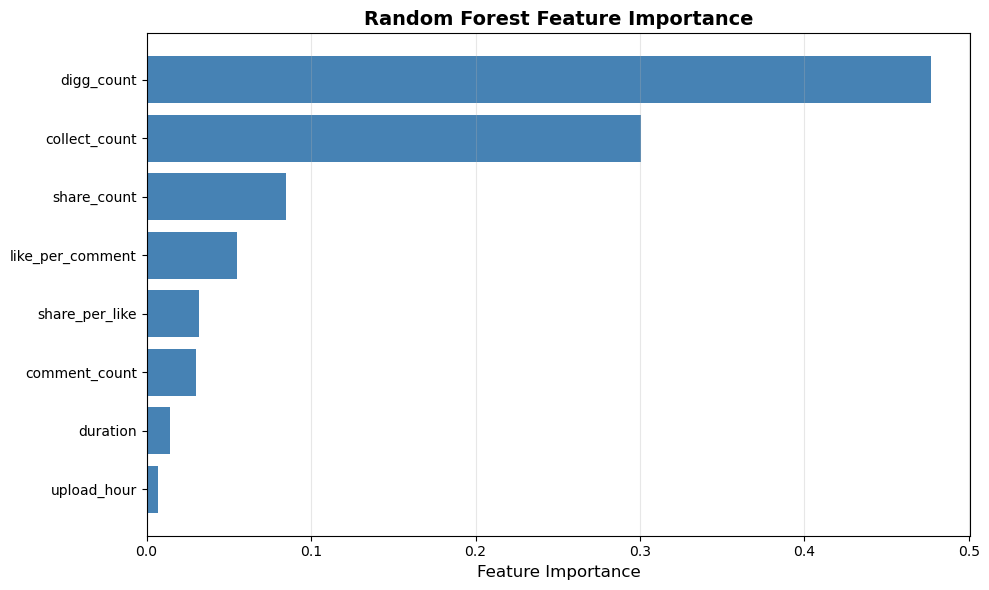

In [109]:
# Feature importance visualization
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='steelblue')
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Random Forest Feature Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


In [110]:
# Sample predictions vs actual from test set
test_preds_log = best_rf.predict(X_test_scaled)
test_preds = np.expm1(test_preds_log)
test_actual = np.expm1(y_test_log)

results_df = pd.DataFrame({
    'Actual Views': test_actual.values,
    'Predicted Views': test_preds,
    'Error %': ((test_preds - test_actual.values) / test_actual.values * 100).round(2)
})

# Show sample results
print("Sample Predictions (first 10):")
print(results_df.head(10).to_string(index=False))



Sample Predictions (first 10):
 Actual Views  Predicted Views  Error %
    6000000.0     6.393115e+06     6.55
   10200000.0     1.072069e+07     5.10
    7400000.0     9.511719e+06    28.54
   11600000.0     2.160183e+07    86.22
   22200000.0     2.107295e+07    -5.08
   24200000.0     1.715941e+07   -29.09
   47700000.0     3.999811e+07   -16.15
   27100000.0     3.801786e+07    40.29
   23500000.0     2.529885e+07     7.65
    8100000.0     1.000588e+07    23.53
